# **Vignette for `ts-media-bridge`**

This notebook demonstrates how to use the `ts-media-bridge` package to analyze the relationship between Spotify streaming data and New York Times media coverage for Taylor Swift's discography.

## Overview

The `ts-media-bridge` package allows one to:
- Fetch artist and album metadata from Spotify
- Search for articles from the New York Times
- Match articles to specific albums using text analysis
- Analyze patterns in media coverage vs. popularity

## Installation and Setup

Make sure you have the package installed and API keys configured:

```bash
poetry install
```

Create a `.env` file with your API credentials:
```
SPOTIFY_CLIENT_ID=your_id
SPOTIFY_CLIENT_SECRET=your_secret
NYT_API_KEY=your_key
```

In [2]:
# Import the package
from ts_media_bridge import SpotifyClient, NYTClient, match_articles_to_albums
import pandas as pd
import matplotlib.pyplot as plt

## 1. Getting Album Data from Spotify

Fetch Taylor Swift's discography from Spotify.

In [3]:
# Initialize Spotify client
sp = SpotifyClient()

# Taylor Swift's Spotify ID
TS_ID = "06HL4z0CvFAxyc27GXpf02"

# Get albums
df_albums = sp.get_artist_albums_df(TS_ID)
print(f"Found {len(df_albums)} canonical albums\n")

# Display album information
df_albums[['name', 'release_date', 'popularity', 'total_tracks', 'is_rerecording']].head(10)

Found 18 canonical albums



,name,release_date,popularity,total_tracks,is_rerecording
1,The Life of a Showgirl,2025-10-03,100,12,False
4,THE TORTURED POETS DEPARTMENT,2024-04-18,82,16,False
6,1989 (Taylor's Version),2023-10-26,82,21,True
7,Speak Now (Taylor's Version),2023-07-07,80,22,True
10,Midnights,2022-10-21,82,13,False
11,Red (Taylor's Version),2021-11-12,83,30,True
12,Fearless (Taylor's Version),2021-04-09,81,26,True
13,evermore (deluxe version),2021-01-07,77,17,False
14,evermore,2020-12-11,76,15,False
16,folklore (deluxe version),2020-08-18,75,17,False


## 2. Searching NYT for Articles

Search the New York Times for articles about Taylor Swift.

**Note:** This will take ~30-40 seconds due to rate limiting (the NYT API allows 10 calls per minute).

In [4]:
# Initialize NYT client
nyt = NYTClient()

# Search for Taylor Swift articles (5 pages = 50 articles)
print("Fetching articles from NYT (this takes ~30 seconds)...")
docs = nyt.search_taylor_swift(pages=5)

# Convert to DataFrame
df_articles = nyt.docs_to_df(docs)
df_articles = df_articles.drop_duplicates(subset=['web_url'])

print(f"\nFound {len(df_articles)} unique articles\n")
df_articles[['pub_date', 'headline', 'section']].head()

Fetching articles from NYT (this takes ~30 seconds)...
[NYT] Rate limiting: waiting 5.4s before next request...
[NYT] Rate limiting: waiting 5.8s before next request...
[NYT] Rate limiting: waiting 5.6s before next request...
[NYT] Rate limiting: waiting 5.7s before next request...

Found 47 unique articles



,pub_date,headline,section
0,2025-10-23T09:03:57Z,Sea Otters and Museums Are Feeling Taylor Swif...,Arts
1,2025-09-11T09:00:11Z,Stephanie Burt on Taylor Swift and Some Other ...,Books
2,2025-10-04T17:20:12Z,"In Taylor’s Version, Ophelia Has a Fairy-Tale ...",Arts
3,2025-10-03T23:14:21Z,Reaching for a Connection to Taylor Swift,U.S.
4,2025-08-18T09:03:25Z,Anticipating Taylor Swift’s ‘The Life of a Sho...,Arts


## 3. Matching Articles to Albums

Use text matching to connect articles with specific albums.

In [5]:
# Match articles to albums
df_matched = match_articles_to_albums(df_albums, df_articles)
print(f"Matched {len(df_matched)} article-album pairs\n")

# Show sample matches
df_matched[['album_base_title', 'headline', 'match_in']].head(10)

Matched 14 article-album pairs



,album_base_title,headline,match_in
0,The Life of a Showgirl,"In Taylor’s Version, Ophelia Has a Fairy-Tale ...",snippet
1,The Life of a Showgirl,Anticipating Taylor Swift’s ‘The Life of a Sho...,headline
2,The Life of a Showgirl,Why Is Taylor Swift So Polarizing? And Other B...,snippet
3,The Life of a Showgirl,Breaking Down Taylor Swift’s ‘The Life of a Sh...,headline
4,The Life of a Showgirl,Taylor Swift Conquered With the Eras Tour. Now...,snippet
5,The Life of a Showgirl,Taylor Swift Keeps Getting Bigger. Can the Mus...,snippet
6,The Life of a Showgirl,A Taylor Swift Mystery: Which Musso and Frank’...,snippet
7,The Life of a Showgirl,When Did You Know Taylor Swift Would Be a Pop ...,snippet
8,The Life of a Showgirl,Taylor Swift Fans Try to Decode ‘The Life of a...,headline
9,The Life of a Showgirl,"When Taylor Swift Met Pop’s Supreme Hitmaker, ...",snippet


## 4. Analyzing NYT Coverage by Album

Count how many articles mention each album.

In [7]:
# Count mentions per album
mentions = (
    df_matched.groupby("album_base_title")["web_url"]
    .nunique()
    .reset_index(name="nyt_article_count")
    .sort_values("nyt_article_count", ascending=False)
)

print("NYT Article Mentions by Album:")
print(mentions.to_string(index=False))

NYT Article Mentions by Album:
      album_base_title  nyt_article_count
The Life of a Showgirl                 11
                   Red                  1
            reputation                  1


## 5. Comparing Spotify Popularity with NYT Coverage

Visualize the relationship between streaming popularity and media coverage.

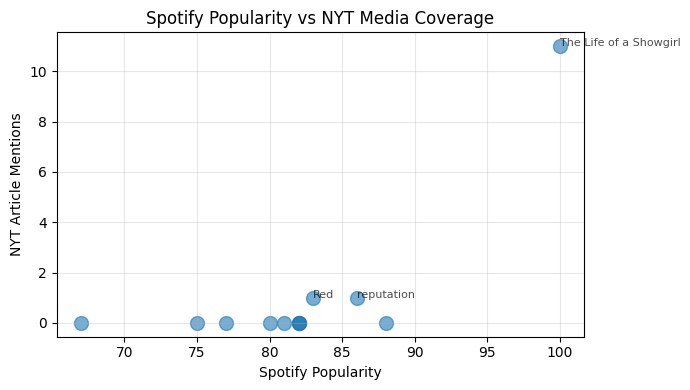

In [12]:
# Merge Spotify data with NYT counts
df_viz = df_albums[['base_title', 'release_date', 'popularity', 'is_rerecording']].drop_duplicates(subset=['base_title'])
df_viz = df_viz.merge(mentions, left_on='base_title', right_on='album_base_title', how='left')
df_viz['nyt_article_count'] = df_viz['nyt_article_count'].fillna(0)

# Scatter plot
plt.figure(figsize=(7, 4))
plt.scatter(df_viz['popularity'], df_viz['nyt_article_count'], s=100, alpha=0.6)
for _, row in df_viz.iterrows():
    if row['nyt_article_count'] > 0:
        plt.annotate(row['base_title'], (row['popularity'], row['nyt_article_count']), 
                     fontsize=8, alpha=0.7)
plt.xlabel('Spotify Popularity')
plt.ylabel('NYT Article Mentions')
plt.title('Spotify Popularity vs NYT Media Coverage')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Comparing Original Albums vs Taylor's Versions

In [10]:
# Analyze coverage by album type
df_viz['album_type'] = df_viz['is_rerecording'].map({True: "Taylor's Version", False: 'Original'})
tv_analysis = df_viz.groupby('album_type')['nyt_article_count'].agg(['mean', 'sum', 'count'])

print("Original Albums vs Taylor's Versions:")
print(tv_analysis)

Original Albums vs Taylor's Versions:
                  mean   sum  count
album_type                         
Original          1.50  12.0      8
Taylor's Version  0.25   1.0      4


## Key Findings

1. **Weak correlation between Spotify popularity and NYT coverage** - Media attention doesn't necessarily align with streaming numbers

2. **Recency bias** - Newer albums dominate coverage regardless of popularity

3. **Original albums get more coverage** - Taylor's Versions receive less media attention than original releases

4. **Cultural moments matter** - Albums released during significant events (e.g., *folklore* during pandemic) receive disproportionate coverage

## Saving Results

Save your analysis results for further exploration:

In [ ]:
# Save matched articles
df_matched.to_csv('matched_articles.csv', index=False)

# Save combined analysis
df_viz.to_csv('combined_analysis.csv', index=False)

print("Results saved!")

## Conclusion

This vignette demonstrated the core functionality of `ts-media-bridge`:
- Fetching data from Spotify and NYT APIs
- Matching articles to albums
- Analyzing patterns in media coverage

For more details, see the [documentation](https://ts-media-bridge.readthedocs.io) or explore the source code on [GitHub](https://github.com/yourusername/ts-media-bridge).